## Better Experimentation Manager: example notebook

In this example notebook, we use the different utilities provided by BEM to train and sample from a simple diffusion model (DDPM).

The structure of the repo is as follows:
- **datasets**: provides some default datasets (simple 2d datasets, image datasets etc.)
- **models**:  provides some default neural network architectures (MLP, U-net etc.)
- **evaluate**: provides some default metrics (FID, precision/recall, density/coverage, wasserstein etc.)
- **manage**: provides multiple useful scripts to initialize, manage and run experiments, see the rest of this notebook

In addition, we provide:
- **configs**: yml files from which to load pre-defined configuration dictionnaries
- **generative_methods**: one example [DDPM](https://arxiv.org/abs/2006.11239) implementation (it is a [DLPM](https://github.com/darioShar/DLPM) implementation, which reverts to DDPM when $\alpha =2$).
- **scripts**: example scripts
    - `run.py`: do a training run
    - `eval.py`: evaluate a saved model
    - `display.py`: get a plot and an animation from a saved model
    - `script_utils.py`: some utility functions used by previous scripts

## Load the configuration into a dictionnary / define the configuration dictionnary 'p'

In [15]:
from manage.files import FileHandler
import os

def print_dict(d, indent = 0):
    for k, v in d.items():
        if isinstance(v, dict):
            print('\t'*indent, k, '\t:')
            print_dict(v, indent + 1)
        else:
            print('\t'*indent, k, ':', v)

config_path = 'configs/'
checkpoint_dir = 'checkpoints'
experiment_name = 'tmp'

p = FileHandler.get_param_from_config(config_path, 'ddpm_2d_data.yml')

# Here, DLPM with alpha = 2.0 reverts to classical DDPM (diffusion model)
p['method'] = 'dlpm'
p['dlpm']['alpha'] = 2.0
p['data']['dataset'] = 'gmm_grid'
p['data']['d'] = 2 # can choose data dimension =1 , will project on the first dimension

# You can modify run-related parameters in the configuration dictionary
print('Parameters for the run : (epochs, frequency of evaluation (eval per x epoch), frequency of checkpoints (checkpoint per x epoch), tqdm print progress):')
p['run']['epochs'] = 20
p['run']['eval_freq'] = None
p['run']['checkpoint_freq'] = 10
p['run']['print_progress'] = True

print_dict(p)

Parameters for the run : (epochs, frequency of evaluation (eval per x epoch), frequency of checkpoints (checkpoint per x epoch), tqdm print progress):
 seed : None
 data 	:
	 dataset : gmm_grid
	 d : 2
	 alpha : 2.0
	 isotropic : True
	 n : 3
	 n_samples : 32000
	 std : 0.1
	 theta : 3.0
	 weights : [0.01, 0.1, 0.3, 0.2, 0.02, 0.15, 0.02, 0.15, 0.05]
 method : dlpm
 lim 	:
	 alpha : 1.8
	 clamp_a : None
	 clamp_eps : None
	 reverse_steps : 100
	 isotropic : True
	 rescale_timesteps : True
 dlpm 	:
	 alpha : 2.0
	 reverse_steps : 100
	 isotropic : True
	 mean_predict : EPSILON
	 rescale_timesteps : True
	 var_predict : FIXED
	 scale : scale_preserving
	 input_scaling : False
 eval 	:
	 data_to_generate : 5000
	 real_data : 5000
	 batch_size : 1024
	 dlpm 	:
		 deterministic : False
		 reverse_steps : 100
		 clip_denoised : False
		 clamp_a : None
		 clamp_eps : None
	 lim 	:
		 deterministic : False
		 reverse_steps : 100
 model 	:
	 architecture : mlp
	 mlp 	:
		 act : silu
		 dropout_

## Initialize Generative Method

In [16]:
import os
from manage.files import FileHandler
from generative_methods.GenerativeLevyProcess import GenerativeLevyProcess
from data.data import CurrentDatasetInfo, Modality, StateSpace


''' This function should return an object which implements the following functions:

training_losses - returns the training losses of the model. Its arguments are:
    models - a list of trained models
    x_start - the starting point of the trajectory
    model_kwargs - a dictionary of keyword arguments to pass to the model
    **kwargs - additional keyword arguments

sample - returns a sample trajectory from the model. Its arguments are:
    models - a list of trained models
    shape - the shape of the data to generate
    **kwargs - additional keyword arguments
    
'''
def init_method_ddpm(p):
    chosen_gen_model = p['method']
    assert chosen_gen_model in ['dlpm'], f"In this implementation, chosen method should be in 'dlpm', got {chosen_gen_model}"
    method = GenerativeLevyProcess(alpha = p[chosen_gen_model]['alpha'],
                                device = p['device'],
                                reverse_steps = p[chosen_gen_model]['reverse_steps'],
                                rescale_timesteps = p[chosen_gen_model]['rescale_timesteps'],
                                isotropic = p[chosen_gen_model]['isotropic'],
                                model_mean_type = p[chosen_gen_model]['mean_predict'],
                                model_var_type = p[chosen_gen_model]['var_predict'],
                                scale = p[chosen_gen_model]['scale'],
                                input_scaling = p[chosen_gen_model]['input_scaling'],
    )
    return method


## Initialize neural network, optimizer, learning schedule

In [17]:
import torch
import torch.nn as nn
from models.unet import UNetModel
from models.VAE import VAEGaussianBernoulli, VAESimple
from models.MLP import MLPModel
from models import unet_model, discrete_unet_model
import torch.optim as optim
from transformers import get_scheduler

''' at any point during the program execution, will give information about the current dataset being used '''
from data.data import CurrentDatasetInfo, Modality, StateSpace



''' 
This function should return a neural network model object.
The model object can be initialized with the parameters in the dictionary p.
The model object should be moved to the device specified in p['device']

You can retrieve the modality of the data and the state space of the data using the CurrentDatasetInfo class.
The modality of the data can be accessed using CurrentDatasetInfo.modality
The state space of the data can be accessed using CurrentDatasetInfo.state_space
'''

def init_model(p):
    modality = CurrentDatasetInfo.modality
    state_space = CurrentDatasetInfo.state_space
    
    assert state_space == StateSpace.CONTINUOUS, 'only continuous state space supported in our example file'
    model = None
    arch = p['model']['architecture']
    print('Initializing model with architecture {}'.format(arch))
    if arch == 'mlp':
        model = MLPModel(p)
    elif arch == 'transformer':
        assert False, 'transformer model only implemented for discrete data'
        
    elif p['model']['architecture'] == 'vae':
        image_size = p['data']['image_size']
        model = VAESimple(
            shape = (1, image_size, image_size),
            device=p['device'],
            **p['model']['vae'])
        
    elif p['model']['architecture'] == 'unet':
        print('Using {} implementation'.format(p['model']['unet']['model_type']))
        if p['model']['unet']['model_type'] == 'ddpm':
            model = unet_model(p)
        else:
            raise ValueError('model type {} not recognized'.format(p['model']['unet']['model_type']))
    else:
        raise ValueError('model architecture {} not recognized'.format(p['model']['architecture']))
    
    assert model is not None, 'model could not be initialized with architecture = {}'.format(p['model']['architecture'])
    
    return model.to(p['device'])



''' 
This function should return an optimizer object.
The optimizer object can be initialized with the parameters in the dictionary p.
'''
def init_optimizer(p, model):
    optimizer = None
    if p['optim']['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=p['optim']['lr'], betas=(0.9, 0.999)) # beta_2 0.95 instead of 0.999)
    elif p['optim']['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=p['optim']['lr'])
    elif p['optim']['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=p['optim']['lr'])
    else:
        raise ValueError('optimizer {} not recognized'.format(p['optim']['optimizer']))
    return optimizer


''' 
This function should return a learning schedule object.
The learning schedule object can be initialized with the parameters in the dictionary p.
'''
def init_learning_schedule(p, optim):
    if p['optim']['schedule'] == None:
        return None
    
    if p['optim']['schedule'] == 'steplr':
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optim,
                                                    step_size= p['optim']['lr_step_size'], 
                                                    gamma= p['optim']['lr_gamma'], 
                                                    last_epoch=-1)
    else: 
        lr_scheduler = get_scheduler(
            p['optim']['schedule'],
            # "cosine",
            # "cosine_with_restarts",
            optimizer=optim,
            num_warmup_steps=p['optim']['warmup'],
            num_training_steps=p['optim']['lr_steps'],
        )
    return lr_scheduler

''' 
This function should return a dictionary of models, optimizers and learning schedules.
The keys of the dictionaries should be the names of the models, optimizers and learning schedules.
The values should be the corresponding objects.

We use this dictionnary structure because some generative methods require multiple models.
'''
def init_models_optmizers_ls(p):
    model = init_model(p)
    optimizer = init_optimizer(p, model)
    learning_schedule = init_learning_schedule(p, optimizer)
    
    models = {'default': model}
    optimizers = {'default': optimizer}
    learning_schedules = {'default': learning_schedule}
    return models, optimizers, learning_schedules

## Initialize dataset

In [18]:
from data.data import get_dataset, available_datasets

'''
This function returns the dataset to be used in the experiment
Its arguments are:
    p - the parameter dictionary
It returns
    train_dataset - the training torch.Dataset
    test_dataset - the test torch.Dataset
    modality - the modality of the data, either 'image' or 'tensor_rank_two' (i.e., data of shape (Channels, dimensions))
    state_space - the state space of the data, either 'continuous' or 'discrete'
'''
# use default bem function to get dataset
print('Available datasets (bem):')
print_dict(available_datasets())
print('Using bem default dataset initializer')
init_data = get_dataset

Available datasets (bem):
 image : ['cifar10', 'cifar10_lt', 'celeba', 'mnist', 'binary_mnist', 'imagenet', 'tinyimagenet']
 custom : ['gmm_2', 'gmm_grid', 'swiss_roll', 'skewed_levy', 'sas', 'sas_grid', 'saws_1d', 'uniform_saws_1d']
 png : See available png images in the ./data folder
Using bem default dataset initializer


## Run your experiment

You can re-modify the parameter dictionnary

In [19]:
from manage.files import FileHandler
from manage.logger import Logger
from manage.generation import GenerationManager
from manage.training import TrainingManager
from evaluate.EvaluationManager import EvaluationManager
from torch.utils.data import DataLoader
from manage.setup import _get_device, _optimize_gpu, _set_seed
import os


save_dir = os.path.join(checkpoint_dir, experiment_name)

# initialize logger
print('Initializing logger...', end='')
logger = None # implement your own logger
print('Done')

# initialize gpu backend
print('Initializing GPU configuration...')
device = _get_device()
p['device'] = device
print('Device set to', device)

_optimize_gpu(device=device)
if p['seed'] is not None:
    _set_seed(p['seed'])

print('Done')

print('Loading data...')
dataset_files, test_dataset_files, modality, state_space, has_labels = init_data(p)
# implement DDP later on
data = DataLoader(dataset_files, 
                batch_size=p['training']['batch_size'], 
                shuffle=True, 
                num_workers=p['training']['num_workers'])
test_data = DataLoader(test_dataset_files,
                        batch_size=p['training']['batch_size'],
                        shuffle=True,
                        num_workers=p['training']['num_workers'])
# set the current dataset info
CurrentDatasetInfo.set_dataset_info(
            modality = modality, 
            state_space = state_space,
            has_labels=has_labels
)
print('Data modality:{}, state_space:{}, labels={}'.format(modality, state_space, has_labels))
print('Done')


is_image_dataset = (CurrentDatasetInfo.modality == Modality.IMAGE)
print('Preparing evaluation directories...', end='')        
# prepare the evaluation directories
fh = FileHandler(
    exp_name=None,
    eval_name=None,
)
# for custom checkpoint name:
# fh.exp_hash = lambda p : ...
# fh.eval_name = lambda p : ...

gen_data_path, real_data_path = fh.prepare_data_directories(
    p,
    dataset_files, 
    is_image_dataset= is_image_dataset
)
print('Done')

# initialize models, optimizers and learning schedules. They are stored in dictionnaries, in case we need to manage multiple models.
print('Initializing models, optimizers and learning schedules...')
models, optimizers, learning_schedules = init_models_optmizers_ls(p)
print('Done')


# initialize geenrative method
print('Initializing generative method...', end='')
method = init_method_ddpm(p)
# method = init_method_dmpm(p)
print('Done')

# intialize generation manager
print('Initialzing generation manager...', end='')
# these kwargs will be passed to the 'sample' function of the generative method
gen_kwargs = p['eval'][p['method']]
gen_manager = GenerationManager(method, 
                            dataloader=data, 
                            is_image = is_image_dataset,
                            **gen_kwargs)
print('Done')

# run evaluation on train or test data
print('Initializing evaluation manager...', end='')
eval = EvaluationManager(
        method=method,
        gen_manager=gen_manager,
        dataloader=data, # or test_data
        verbose=True, 
        logger = logger,
        data_to_generate = p['eval']['data_to_generate'],
        batch_size = p['eval']['batch_size'],
        modality = modality,
        state_space = state_space,
        gen_data_path=gen_data_path,
        real_data_path=real_data_path
)
print('Done')

# run training
'''
In p['training'][p['method']]:
- ema_rates, grad_clip will be passed to the training loop function 
- other parameters will be passed to the 'training_losses' function of the generative method
'''
# kwargs goes to manager (ema_rates), train_loop (grad_clip), and eventually to training_losses (monte_carlo...)
print('Initializing training manager...', end='')
train_kwargs = p['training'][p['method']]
trainer = TrainingManager(models,
            data,
            method,
            optimizers,
            learning_schedules,
            eval,
            logger=logger,
            p=p,
            dataset_with_labels=has_labels,
            eval_freq = p['run']['eval_freq'],
            checkpoint_freq = p['run']['checkpoint_freq'],
            **train_kwargs
            )
print('Done')

Initializing logger...Done
Initializing GPU configuration...
using device mps
Device set to mps
Done
Loading data...
loading dataset gmm_grid
Dataset type set to: tensor_rank_two, has_labels=continuous
Data modality:tensor_rank_two, state_space:continuous, labels=False
Done
Preparing evaluation directories...Done
Initializing models, optimizers and learning schedules...
Initializing model with architecture mlp
Done
Initializing generative method...Done
Initialzing generation manager...Done
Initializing evaluation manager...Done
Initializing training manager...Done


In [20]:
# for custom checkpoint names:
# fh.exp_hash - lambda p : (string)
# fh.eval_name - lambda p : (string)

In [21]:
from manage.checkpoints import save_experiment, load_experiment

# potentially load models from an existing checkpoint
load_experiment(
    p=p,
    trainer=trainer,
    fh=fh,
    save_dir=save_dir,
    checkpoint_epoch = None, # if None, will load the latest checkpoint
)

# this will be called every checkpoint_freq epochs
def checkpoint_callback(checkpoint_epoch):
    saved_files = save_experiment(
        p=p,
        trainer = trainer,
        fh = fh,
        save_dir = save_dir,
        checkpoint_epoch = checkpoint_epoch,
    )
    print('saved files', saved_files)

''' 
Run the training loop wuth parameters from the configuration file. 
Specifying arguments here will overwrite the arguments obtained from the configuration file, for this training run
'''
trainer.train(
    total_epoch=p['run']['epochs'], 
    checkpoint_callback=checkpoint_callback,
    no_ema_eval=False, # if True, will not run evaluation with EMA models
    progress=True, # if True, will print progress bar
)


Loading trained model at iteration 20
loading from model file checkpoints/tmp/gmm_grid/model_datas_gmm_g_metho_dlpm_archi_mlp_20.pt
loading model default from checkpoint
loading optimizer default from checkpoint
loading learning schedule default from checkpoint
loading from eval file checkpoints/tmp/gmm_grid/eval_datas_gmm_g_metho_dlpm_archi_mlp.pt
training model to epoch 20 from epoch 20 ...


In [22]:
# in any case, save the final model
save_experiment(
    p=p,
    trainer = trainer,
    fh = fh,
    save_dir = save_dir,
    checkpoint_epoch =p['run']['epochs']
)

('checkpoints/tmp/gmm_grid/model_datas_gmm_g_metho_dlpm_archi_mlp_20.pt',
 'checkpoints/tmp/gmm_grid/parameters_datas_gmm_g_metho_dlpm_archi_mlp.pt',
 'checkpoints/tmp/gmm_grid/eval_datas_gmm_g_metho_dlpm_archi_mlp.pt')

## Evaluate a trained model

In [23]:
eval_freq = p['run']['eval_freq'] # if None, will evaluate only the last checkppint
max_epoch = p['run']['epochs']
if eval_freq is None:
    eval_freq = max_epoch

for epoch in range(eval_freq, max_epoch + 1, eval_freq):
    print('Evaluating model at epoch {}'.format(epoch))
    load_experiment(
        p=p,
        trainer = trainer,
        fh = fh,
        save_dir = save_dir,
        checkpoint_epoch=epoch)
    # evalute ema models
    trainer.evaluate(evaluate_emas=False)
    trainer.evaluate(evaluate_emas=True)
    paths = save_experiment(
        p=p,
        trainer = trainer,
        fh = fh,
        save_dir = save_dir,
        checkpoint_epoch = epoch,
        files=['eval', 'param'], 
        new_eval_subdir=True, 
    )
    print('Saved (model, eval, param) in ', paths)

Evaluating model at epoch 20
loading from model file checkpoints/tmp/gmm_grid/model_datas_gmm_g_metho_dlpm_archi_mlp_20.pt
loading model default from checkpoint
loading optimizer default from checkpoint
loading learning schedule default from checkpoint
loading from eval file checkpoints/tmp/gmm_grid/eval_datas_gmm_g_metho_dlpm_archi_mlp.pt
evaluating non-ema model
modality = tensor_rank_two, state_space = continuous, 5000 samples to generate for evaluation
computing metrics...
wasserstein
mmd
msle
prd
results:
losses_batch = 0.6411691308021545
wass = 0.05258601770207369
mmd = 0.06303706020116806
msle = 0.178482323884964
f_1_pr = 0.8861871949895382
fig = None
Saved (model, eval, param) in  (None, 'checkpoints/tmp/gmm_grid/new_eval_datas_gmm_g_metho_dlpm_archi_mlp_deter_False_rever_100_clip__False_clamp_None_clamp_None/eval_deter_False_rever_100_clip__False_clamp_None_clamp_None_20.pt', 'checkpoints/tmp/gmm_grid/new_eval_datas_gmm_g_metho_dlpm_archi_mlp_deter_False_rever_100_clip__False_

## Inspect trained model, generate samples etc.

In [24]:
# the trained model is in exp.models 
print('trained model is', type(models['default']))

# the generative method is in exp.method
print('generative method is', type(method))

# for DLPM, the model outputs the epsilon approximation. you can compute the correspodning score with the corresponding DLPM function
def score_model_dlpm(models, x, t):
    model = models['default']
    model.eval()
    with torch.inference_mode():
        eps = model(x, t)
        score = method.dlpm.predict_score_from_eps(x, t, eps)
    return score

def ode_drift_dlpm(models, x, t):
    model = models['default']
    model.eval()
    with torch.inference_mode():
        eps = model(x, t)
        ode_drift = method.dlpm.predict_ode_drift_from_eps(x, t, eps)
    return ode_drift

trained model is <class 'models.MLP.MLPModel'>
generative method is <class 'generative_methods.GenerativeLevyProcess.GenerativeLevyProcess'>


In [25]:
gen_manager.generate(models, 
                    nsamples=10000, 
                    reverse_steps=100, 
                    print_progression=True, 
                    get_sample_history=True)
generated_samples = gen_manager.samples
generated_samples_history = gen_manager.history
data_samples = gen_manager.load_original_data(10000)

100%|██████████| 100/100 [00:00<00:00, 121.41it/s]


## display generated data

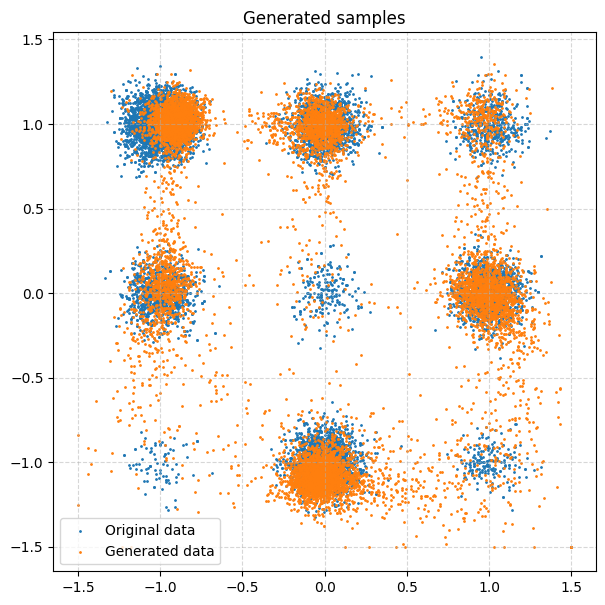

In [26]:
from manage.display import get_plot, get_animation
import matplotlib.pyplot as plt

tmp_gen = generated_samples.clamp(-1.5, 1.5)
tmp_data = data_samples.clamp(-1.5, 1.5)


fig = get_plot(tmp_gen, tmp_data, figsize=(7, 7), s = 1)
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.title('Generated samples')
plt.show() 



Generating animation, with 100 frames


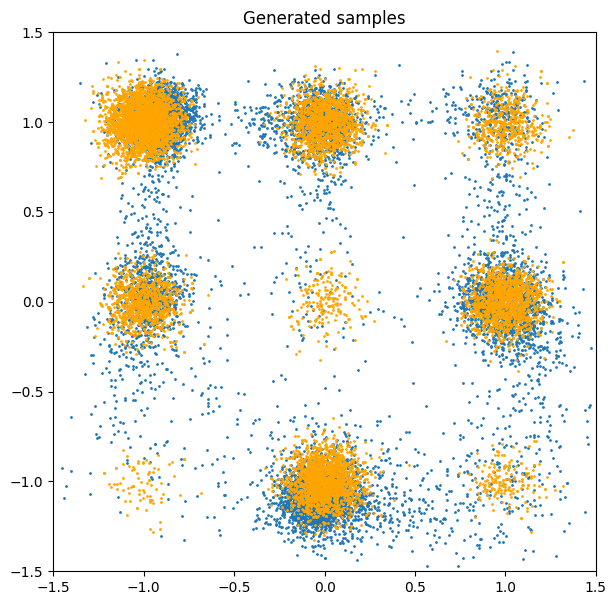

In [27]:

anim = get_animation(method=method,
                     generated_data_history = generated_samples_history, 
                     original_data= data_samples, 
                     is_image = False, 
                     title='Generated samples',
                     figsize=(7, 7), 
                     s = 1)

anim.save('generated_samples.mp4')